# Fun with LinkedIn Queens

We start with installing (or checking) that we have access to OR-tools for constraint solving and to Pillow for manipulating images in python.

In [ ]:
!pip install -U --user ortools
!pip install -U --user Pillow

In [1]:
import itertools as it
from matplotlib import pyplot as plt
import numpy as np
from ortools.sat.python import cp_model
import pathlib as paths
from PIL import Image, ImageOps
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
rng = np.random.default_rng(seed=2024)

## A Constraint Model to Place the Queens
This is my first attempt with OR-tools - we want to place the queens so that:
- each row and each column has exactly one queen
- no queens are adjacent, even diagonally
- each colour region only has one queen

The instance should specify:
- the size of the board
- the colour identifier of each square, given as a list of lists of colour IDs, the outer list containing rows, the inner list representing the individual cells

In [50]:
def solveBoard(board):
    """Return the column where the queen should be for each row"""

    n = len(board)
    _space = lambda dims: it.product(range(n), repeat=dims)
    
    model  = cp_model.CpModel()
    
    # where is the queen in each row?
    queens = [model.new_int_var(0,n-1,f'q_{row:02d}') for row in range(n)]
    model.add_all_different(queens)
    
    # queens in adjacent rows must be at least 2 apart
    for i in range(len(queens)-1):
        q1,q2 = queens[i:i+2]
        _v = model.new_int_var(0,n, f'diff_{q1}_{q2}')
        model.add_abs_equality(_v, q1-q2)
        model.add_linear_constraint(_v, 2, n)
    
    # what colour is the queen occupying in each row?
    q_cols = [model.new_int_var(0,n-1,f'c_{row:02d}') for row in range(n)]
    model.add_all_different(q_cols)

    # only allow the queen to be placed if the colour matches the board
    for r in range(n):
        model.add_allowed_assignments(
            [queens[r], q_cols[r]],
            [[c,board[r][c]] for c in range(n)]
        )
    
        
    solver = cp_model.CpSolver()
    status_code = solver.solve(model)
    status_name = solver.status_name()
    if status_code in (cp_model.FEASIBLE, cp_model.OPTIMAL):
        return [solver.value(q) for q in queens]
    else:
        return []

## From Screenshot to CSP Instance
Look for the screenshots of puzzles collected so far.

In [51]:
que_dir = paths.Path('screenshots')
puzzles = []
thumbs = []
for f_img in list(que_dir.glob("*png")):
    with Image.open(f_img) as im:
        small = ImageOps.contain(im, (128,128)).convert('RGBA')
        pixels = np.array(small)
        thumbs.append(small)
        puzzles.append(pixels[:,:,:3])
print(f"Found {len(puzzles)} puzzles.")

Found 45 puzzles.


The main work of figuring out what we're looking at is done in `learnPalette`.  A number of random starting positions are chosen in the image.  From each starting position, we explore a few nearby pixels and if we find the same colour as the starting pixel (or close enough) then we make it a candidate colour for the puzzle.  However, if we come across a pixel that's different, we back out and forget the colour of the starting pixel.

=== Doing puzzle # 0 === 

Found 7; Kept = 7
[[3 3 3 3 3 3 3]
 [3 6 0 0 0 0 3]
 [3 6 6 6 6 6 3]
 [3 3 3 2 5 6 4]
 [5 5 5 5 5 6 4]
 [5 6 6 6 6 6 4]
 [5 1 1 1 4 4 4]]
Solution:
 [4 2 5 3 0 6 1]
=== Doing puzzle # 1 === 

Found 8; Kept = 8
[[3 3 3 7 7 0 0 0]
 [3 3 7 7 2 0 0 0]
 [3 7 7 2 2 0 0 0]
 [7 7 2 2 5 4 0 0]
 [7 2 2 5 5 4 1 0]
 [6 6 6 4 4 4 1 0]
 [0 0 6 6 1 1 1 0]
 [0 0 0 0 0 0 0 0]]
Solution:
 [0 4 1 5 3 6 2 7]
=== Doing puzzle # 2 === 

Found 9; Kept = 9
[[3 3 3 3 3 3 8 8 8]
 [3 3 3 0 0 0 8 8 8]
 [2 3 5 5 5 5 5 8 8]
 [2 3 5 5 5 5 5 8 8]
 [2 2 5 5 5 5 5 8 8]
 [2 2 5 5 5 5 5 8 4]
 [2 1 1 5 5 5 8 8 4]
 [2 1 1 1 7 4 4 4 4]
 [2 1 1 1 4 4 4 6 6]]
Solution:
 [6 3 1 5 0 8 2 4 7]
=== Doing puzzle # 3 === 

Found 8; Kept = 8
[[3 3 3 3 3 3 3 3]
 [3 7 7 7 7 7 7 3]
 [3 7 0 0 0 0 7 2]
 [3 7 5 4 4 0 7 2]
 [3 7 5 1 4 0 7 2]
 [3 6 5 1 1 1 7 2]
 [3 6 5 5 5 7 7 2]
 [3 6 6 6 6 6 2 2]]
Solution:
 [0 6 2 4 7 5 3 1]
=== Doing puzzle # 4 === 

Found 9; Kept = 9
[[1 1 1 5 5 5 5 7 7]
 [1 1 0 2 2 5 5 7 7]
 [1 1 0 0 2 2 5 7 7]
 [1 1 0 2 2 5 5 4 7]
 [1 1 1 1 5 5 4 4 4]
 [1 3 1 1 1 5 4 6 4]
 [3 3 3 1 1 5 6 6 6]
 [3 8 3 5 5 5 5 5 5]
 [8 8 8 5 5 5 5 5 5]]
Solution:
 [8 2 5 7 3 1 6 4 0]
=== Doing puzzle # 5 === 

Found 9; Kept = 9
[[3 3 3 3 3 8 8 8 0]
 [3 3 3 4 4 2 2 2 0]
 [3 3 3 4 2 2 5 2 2]
 [3 3 2 2 2 5 5 5 2]
 [3 3 2 5 2 5 5 2 2]
 [3 3 2 5 5 5 2 2 1]
 [3 3 2 5 5 5 2 1 1]
 [3 7 2 2 2 2 2 6 1]
 [7 7 7 7 7 7 6 6 1]]
Solution:
 [5 8 3 0 2 4 7 1 6]
=== Doing puzzle # 6 === 

Found 8; Kept = 8
[[3 3 7 7 0 0 0 0]
 [3 2 2 7 7 7 7 0]
 [7 2 5 5 5 5 7 7]
 [7 7 5 4 4 4 4 7]
 [7 7 5 4 1 1 7 7]
 [7 7 5 4 1 6 6 7]
 [7 7 7 4 7 6 7 7]
 [7 7 7 7 7 7 7 7]]
Solution:
 [0 7 1 6 4 2 5 3]
=== Doing puzzle # 7 === 

Found 11; Kept = 9
[[1 1 1 1 1 1 6 6 6]
 [1 1 1 1 1 1 1 1 8]
 [1 3 3 3 7 1 1 1 8]
 [1 1 1 1 7 1 1 1 8]
 [1 1 1 1 7 1 1 1 1]
 [1 1 1 1 1 2 2 2 1]
 [1 1 1 1 1 1 0 0 0]
 [1 1 5 5 5 1 1 1 1]
 [1 4 4 4 1 1 1 1 1]]
Solution:
 [6 8 2 4 0 5 7 3 1]
=== Doing puzzle # 8 === 

Found 9; Kept = 9
[[3 3 8 8 8 8 0 0 0]
 [3 8 8 8 2 2 2 8 0]
 [8 8 8 8 8 8 2 8 0]
 [8 5 8 8 8 8 2 8 8]
 [8 5 8 8 8 8 4 8 8]
 [8 5 5 5 8 4 4 8 8]
 [8 8 8 8 1 8 8 8 7]
 [6 8 8 1 1 8 8 8 7]
 [6 6 8 8 8 8 7 7 7]]
Solution:
 [1 5 8 3 6 2 4 0 7]
=== Doing puzzle # 9 === 

Found 10; Kept = 10
[[4 4 4 4 4 4 4 9 4 4]
 [4 4 4 4 4 4 9 9 9 4]
 [4 4 4 0 4 4 4 9 4 4]
 [4 4 4 2 2 2 4 4 4 4]
 [4 4 6 6 6 6 6 6 4 4]
 [4 5 5 5 5 5 5 5 5 4]
 [4 4 1 1 8 8 7 7 4 4]
 [3 3 1 1 8 8 7 7 3 3]
 [3 3 8 8 8 8 8 8 8 3]
 [3 3 3 3 3 3 3 3 3 3]]
Solution:
 [0 8 3 5 7 1 6 2 4 9]


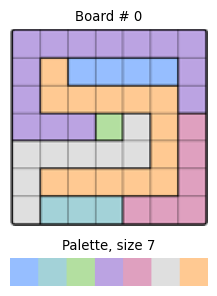

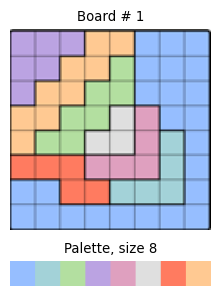

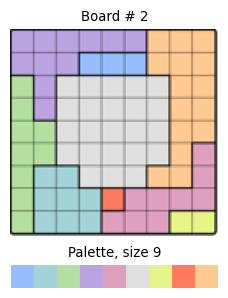

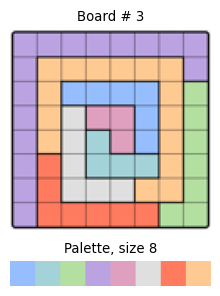

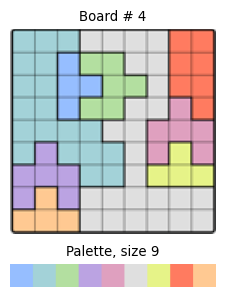

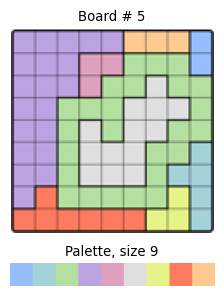

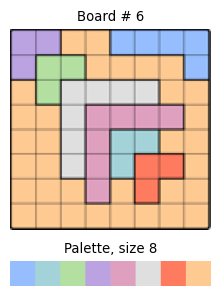

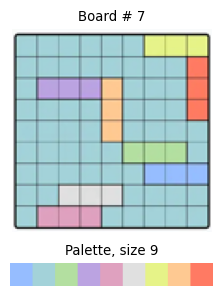

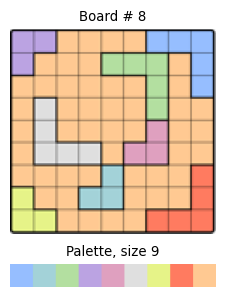

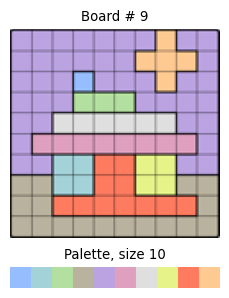

In [54]:
N_STA = int(1e4)
N_NEI = 16
D_NEI = 4
TOO_CLOSE = 3
PAL_WID = 32

def learnPalette(p, n_starts=N_STA, n_neighbours=N_NEI, dist_neighbours=D_NEI,
                 same_thresh=TOO_CLOSE):
    """Use the pixels in an image to work out the 'real' colours in a puzzle """
    keep = set()
    for _ in tqdm.tqdm(range(n_starts),leave=False):
        homeidx = tuple([rng.integers(x) for x in p.shape[:2]])
        homecol = p[homeidx]
        if homecol.sum() > 750 or homecol.sum() < 100: # ignore black and white
            continue
        good = True
        for _ in range(n_neighbours):
            newidx = np.array(homeidx) + np.array(rng.integers(dist_neighbours,size=2))
            try:
                newcol = p[tuple(newidx.tolist())]
            except IndexError: # looking outside the grid?
                good=False
                break
            if not np.array_equal(homecol,newcol):
                good=False
                break
        if good:
            keep.add(tuple(homecol.tolist()))
    # mark as a duplicate any colour which is close enough to another colour
    dupes = set(
        [b for a, b in it.combinations(keep,2)
         if np.max(np.abs(np.array(a)-np.array(b))) < same_thresh]
    )
    cols = keep - dupes
    print(f"Found {len(keep)}; Kept = {len(cols)}")
    return cols


def drawPuzzleAndPalette(p,cols):
    """Show the puzzle and the extracted palette"""
    pal = np.zeros(shape=(PAL_WID,len(cols)*PAL_WID,3),dtype=np.int8)
    for j, (r,g,b) in enumerate(sorted(cols)):
        pal[:,j*PAL_WID:(j+1)*PAL_WID] = np.array([r,g,b])
    fig,axs = plt.subplots(2,1,height_ratios=(len(cols),1),figsize=(2.4,3))
    plt.rcParams.update({'font.size': 8})
    ax = axs[0]
    ax.imshow(Image.fromarray(p))
    ax.set_axis_off()
    ax.set_title(f"Board #{i:2d}")
    ax = axs[1]
    ax.set_axis_off()
    ax.set_title(f"Palette, size {len(cols)}")
    ax.imshow(Image.fromarray(pal,mode='RGB'))
    fig.tight_layout()


def makeConstraintInstance(p,cols):
    """Generate a row,column parameter array to describe a given puzzle """
    # grab the central pixel of each cell
    n = len(cols)
    w = p.shape[0] / n
    centres = np.array([ [p[int(w/2+w*r)][int(w/2+w*c)]  for c in range(n)] for r in range(n)])
    # fix colours to nearest known
    for r,c in it.product(range(n),repeat=2):
        centres[r,c] = sorted(cols, key=lambda rgb:np.sum(np.abs(centres[r,c] - rgb)))[0]
    centre_cols = [x.tolist() for x in np.unique(np.array(centres).reshape(-1,3),axis=0)]
    assert len(centre_cols)==n, "Mismatch between colours in centres vs expected palette"
    board = [ [centre_cols.index(c.tolist()) for c in r] for r in centres]
    print(np.array(board))
    # print(f"letting n = {n}\nletting board={board}")
    return board


puzzle_idxs = np.random.choice(range(len(puzzles)),replace=False,size=10)
for i, p in enumerate([puzzles[i] for i in puzzle_idxs]):
    print(f"=== Doing puzzle #{i:2d} === ",end='')
    cols = learnPalette(p)
    drawPuzzleAndPalette(p, cols)
    params = makeConstraintInstance(p, cols)
    q_pos = solveBoard(params)
    print(f"Solution:\n {np.array(q_pos)}")
